# How to work with ERA5 land on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the `reanalysis-era5-land-no-antartica-v0.zarr` datset on Earth Data Hub.

The first goal is to compute the total precipitation observed during the Storm Daniel event, i.e. from 6 to 7 September 2023, in Greece, and compare it with the average 1991-2020 precipitation in the same area.

The second goal is to compare the 2023 cumulative precipitation on a specific location in Greece interland, with the cumulative precipitation of each year between 1991 and 2020 on the same location.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "s3://ecmwf-era5-land/reanalysis-era5-land-no-antartica-v0.zarr", 
    chunks={}, 
    engine="zarr"
).astype("float32")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 647208, latitude: 1472, longitude: 3600)
Coordinates:
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -56.9 -57.0 -57.1
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1950-01-01 ... 2023-10-31T23:00:00
Data variables:
    ssr         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-18T20:02 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## Storm Daniel precipitation VS average September precipitation 1991-2022

### 1. Data selection

First, we perform a geographical selection corresponding to the Greece area:

In [2]:
tp = ds.tp
tp_greece = tp.sel(**{"latitude": slice(41, 34), "longitude": slice(19, 28)})
tp_greece

<xarray.DataArray 'tp' (valid_time: 647208, latitude: 70, longitude: 90)>
dask.array<getitem, shape=(647208, 70, 90), dtype=float32, chunksize=(2880, 49, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 40.9 40.8 40.7 40.6 ... 34.3 34.2 34.1 34.0
  * longitude   (longitude) float64 19.0 19.1 19.2 19.3 ... 27.6 27.7 27.8 27.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1950-01-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

Second, we further select only two days: september 6 and 7, 2023. This greatly reduces the amount of data that will be downloaded from EDH.

In [3]:
tp_greece_storm_daniel = tp_greece.sel(valid_time=["2023-09-06", "2023-09-07"])
tp_greece_storm_daniel

<xarray.DataArray 'tp' (valid_time: 2, latitude: 70, longitude: 90)>
dask.array<getitem, shape=(2, 70, 90), dtype=float32, chunksize=(2, 49, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 40.9 40.8 40.7 40.6 ... 34.3 34.2 34.1 34.0
  * longitude   (longitude) float64 19.0 19.1 19.2 19.3 ... 27.6 27.7 27.8 27.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 2023-09-06 2023-09-07
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

At this point, the selection is small enough to call `.compute()` on it, which will trigger the download of the data and load it in memory. 

We can measure the time it takes:

In [4]:
%time

tp_greece_storm_daniel = tp_greece_storm_daniel.compute()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


The data was very small. This didn't take long!

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the total precipitation for the Storm Daniel event. We also convert the unit of measure to `mm`.

In [5]:
tp_greece_storm_daniel_sum = tp_greece_storm_daniel.sum("valid_time")
tp_greece_storm_daniel_sum
tp_greece_storm_daniel_sum = tp_greece_storm_daniel_sum * 1000
tp_greece_storm_daniel_sum.attrs["units"] = "mm"
tp_greece_storm_daniel_sum

<xarray.DataArray 'tp' (latitude: 70, longitude: 90)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 40.9 40.8 40.7 40.6 ... 34.3 34.2 34.1 34.0
  * longitude  (longitude) float64 19.0 19.1 19.2 19.3 ... 27.6 27.7 27.8 27.9
    number     int64 0
    surface    float64 0.0
Attributes:
    units:    mm

### 3. Visualization
Finally, we can plot the Storm Daniel event on a map:

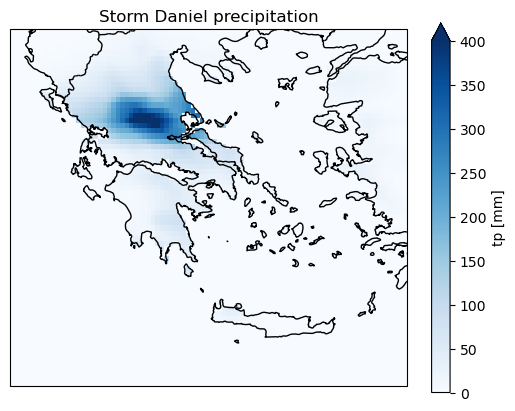

In [6]:
import display
display.map(tp_greece_storm_daniel_sum, vmax=400, title="Storm Daniel precipitation")

We want to compare the total precipitation observed during Storm Daniel with the average precipitation observed in September between 1991 and 2020. 

The same considerations done before apply here. We will first select a subset of the dataset and then compute.

In [7]:
YEARS = [
    "1991", "1992", "1993",
    "1994", "1995", "1996",
    "1997", "1998", "1999",
    "2000", "2001", "2002",
    "2003", "2004", "2005",
    "2006", "2007", "2008",
    "2009", "2010", "2011",
    "2012", "2013", "2014",
    "2015", "2016", "2017",
    "2018", "2019", "2020",
]
DAYS = [
    "01", "02", "03",
    "04", "05", "06",
    "07", "08", "09",
    "10", "11", "12",
    "13", "14", "15",
    "16", "17", "18",
    "19", "20", "21",
    "22", "23", "24",
    "25", "26", "27",
    "28", "29", "30",
]

MONTH_REFERENCE_TIME = [f"{y}-09-{d}" for y in YEARS for d in DAYS]

tp_greece_september_1991_2020 = tp_greece.sel(valid_time=MONTH_REFERENCE_TIME)
tp_greece_september_1991_2020

<xarray.DataArray 'tp' (valid_time: 900, latitude: 70, longitude: 90)>
dask.array<getitem, shape=(900, 70, 90), dtype=float32, chunksize=(30, 49, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 40.9 40.8 40.7 40.6 ... 34.3 34.2 34.1 34.0
  * longitude   (longitude) float64 19.0 19.1 19.2 19.3 ... 27.6 27.7 27.8 27.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1991-09-01 1991-09-02 ... 2020-09-30
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

This is already small enough to call `.compute()` on it.

In [8]:
%time

tp_greece_september_1991_2020 = tp_greece_september_1991_2020.compute()

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 7.87 µs


Now that the data is loaded in memory, we can easily compute the average september total precipitation for the years 1991-2020. We also convert the unit of measure to `mm`:

In [9]:
tp_greece_september_1991_2020_average = (tp_greece_september_1991_2020.sum("valid_time") / len(YEARS))
tp_greece_september_1991_2020_average
tp_greece_september_1991_2020_average = tp_greece_september_1991_2020_average * 1000
tp_greece_september_1991_2020_average.attrs["units"] = "mm"

Finally, we can plot the Storm Daniel event and the September 1991-2020 average side by side:

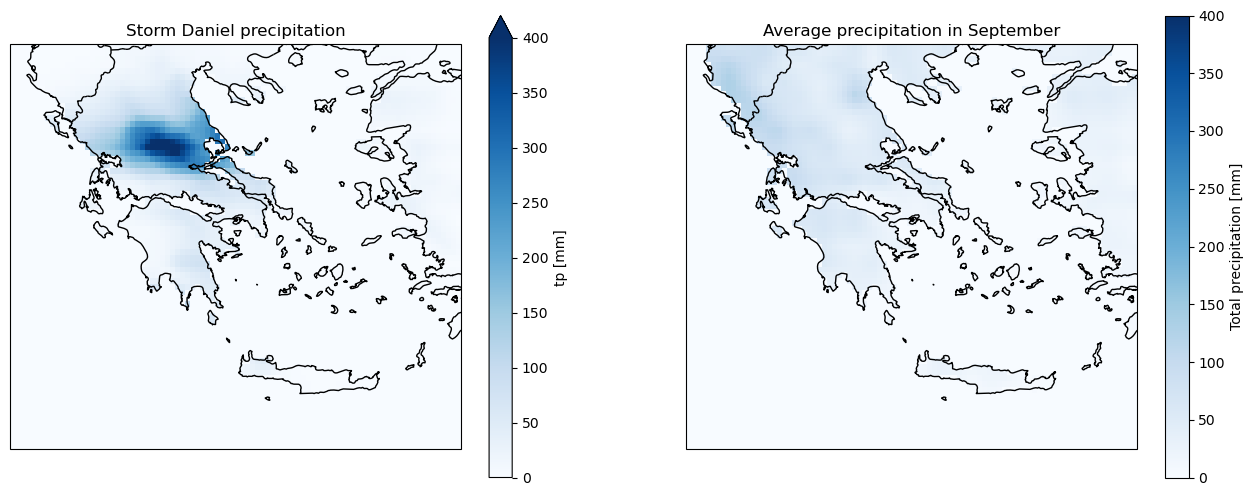

In [10]:
display.maps(
    [tp_greece_storm_daniel_sum, tp_greece_september_1991_2020_average],
    vmax=400,
    axs_set=[
        {"title": "Storm Daniel precipitation"},
        {"title": "Average precipitation in September"},
    ],
)

## 2023 cumulative precipitation VS 1991-2022 comulated precipitation

In this section we will compare the 2023 cumulative precipitation on a specific location in Greece with the cumulative precipitation of each year between 1991 and 2020 (same location).

In [11]:
tp_hinterland_location = ds.tp.sel(**{"latitude": 39.25, "longitude": 21.9, "method": "nearest"})
tp_hinterland_location

<xarray.DataArray 'tp' (valid_time: 647208)>
dask.array<getitem, shape=(647208,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 39.2
    longitude   float64 21.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1950-01-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

This is already small enought to be computed:

In [12]:
%%time

tp_hinterland_location = tp_hinterland_location.compute()

CPU times: user 31.3 s, sys: 7.57 s, total: 38.9 s
Wall time: 18.2 s


With the data already loaded in memory, we can easily select the total daily precipitation (time 00:00) for each  day of the year:

In [15]:
import datetime
tp_hinterland_location_daily_total_2023 = tp_hinterland_location.sel(valid_time="2023").groupby("valid_time.time")[datetime.time()]
tp_hinterland_location_daily_total_1991_2022 = tp_hinterland_location.sel(valid_time=slice("1991", "2020")).groupby("valid_time.time")[datetime.time()]

Using the `display.compare()` method we can plot the cumulative precipitation for all the years between 1991 and 2022 (mean curve in red) and the cumulative precipitation for the year 2023 up to the 31 of October (blue curve)

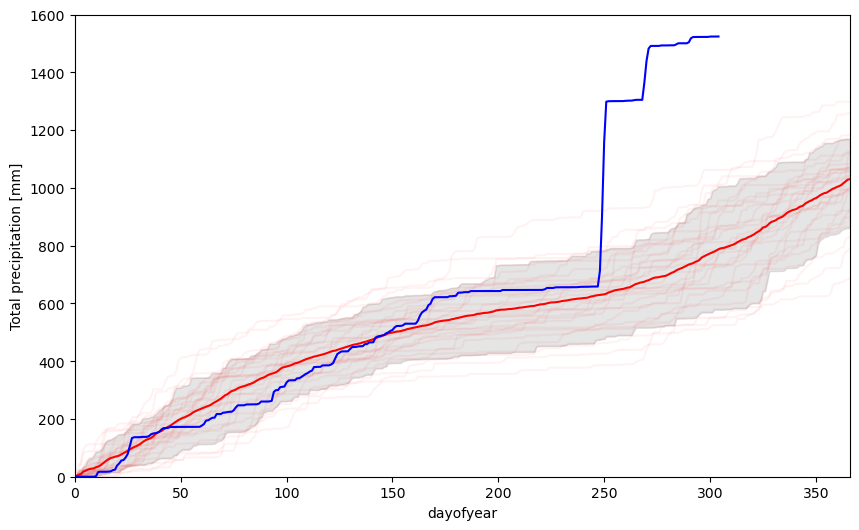

In [17]:
display.compare(tp_hinterland_location_daily_total_2023, tp_hinterland_location_daily_total_1991_2022, time="valid_time", ylim=[0, 1600])